# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 8 de mayo de 2023__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 333

# Apartado 1: Análisis de sentimientos


__Nombres de los estudiantes: Enrique Queipo de Llano Burgos y Alejandro Paz Olalla__

## 1) Carga del conjunto de datos

El fichero `IMBD_Dataset.csv` contiene opiniones de películas clasificadas en 2 categorías diferentes (positiva/negativa).

Este set de datos se creó utilizando el "IMDB Dataset of 50K Movie Reviews", el cual contiene 50,000 reseñas de películas con un sentimiento positivo o negativo adjunto a ellas.

Muestra un ejemplo de cada clase.

Haz un estudio del conjunto de datos. ¿qué palabras aparecen más veces?, ¿tendría sentido normalizar de alguna manera el corpus?

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. Comprueba que la distribución de los ejemplos en las clases es la misma en entrenamiento y test. 

In [2]:
# acceso a google drive

#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import pandas as pd
pd.options.display.max_colwidth = 100
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
import re
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
imbd_file = 'IMDB_Dataset.csv'

df=pd.read_csv(imbd_file)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked....,positive
1,A wonderful little production. <br /><br />The filming technique is very unassuming- very old-ti...,positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei off...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.shape

(50000, 2)

In [7]:
positive = df[df['sentiment'] == 'positive'].sample(random_state=RANDOM_STATE)
positive_index = positive.index.values
negative = df[df['sentiment'] == 'negative'].sample(random_state=RANDOM_STATE)
negative_index = negative.index.values
print('Positive review: ',positive.values)
print('Negative review: ',negative.values)

Positive review:  [['The minutiae of what\'s involved in carrying out a robbery is what makes this one of the best of all heist movies. Then there\'s the robbery itself, a wordless, thirty minute nail-biter that has never been surpassed, followed by what is probably the cinema\'s most pronounced example of dishonor among thieves as things begin to spectacularly unravel, and we have what is unquestionably the greatest of all heist movies.<br /><br />This was a tough and unsentimental film when it first appeared in 1955 and it is just as tough and unsentimental today. (It displays some of the edgy brutality of Dassin\'s earlier "Brute Force"). There isn\'t a flabby moment or duff performance in the entire film and Dassin captures the milieu of seedy clubs and Parisian back streets like no-one else and the final drive through Paris by a dying man is one of the most iconic closing sequences of any movie. A classic.'
  'positive']]
Negative review:  [["Crude, some times crass - to me that's

positive    25000
negative    25000
Name: sentiment, dtype: int64


<AxesSubplot:xlabel='sentiment', ylabel='count'>

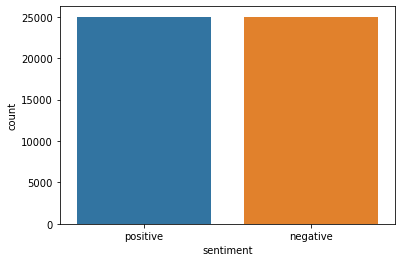

In [8]:
print(df['sentiment'].value_counts())
sns.countplot(x = "sentiment", data = df)

In [9]:
X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
train_sample = X_train.sample(random_state=RANDOM_STATE)
train_sample_index = train_sample.index.values
print('Review ', train_sample_index, train_sample.values)

Review  [24285] ["Kirk and crew land on a lonely planet where the sun is about to explode. They intend to evacuate the inhabitants but find the place deserted except for a Mr. Atoz who operates some sort of high-tech library. Despite trying to get a straight answer from him about everyone's whereabouts, Atoz is indifferent to their questions and insist they must quickly 'make a selection while there is still time'. They have no idea what he's talking about but wander about looking at the hand mirror-like disks on the viewers and they see images of the planet's past. Then, while a disk is in the viewer, Kirk runs through the doorway and is magically transported back in time to what on Earth would look like the time of Louis XIV (the 1660s). When McCoy and Spock follow, a different disk is in the viewer and they are sent to an ice age hell. All too late they realize that the library is a time travel machine and repository.<br /><br />While Kirk's visit is pretty short and not all that ex

[Text(0.5, 1.0, 'Distribution of the train set')]

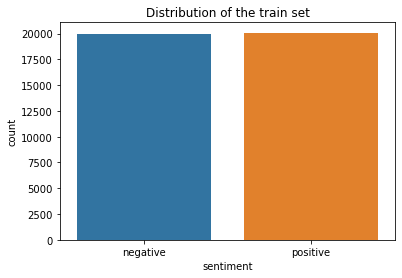

In [10]:
sns.countplot(x=y_train).set(title='Distribution of the train set')

[Text(0.5, 1.0, 'Distribution of the test set')]

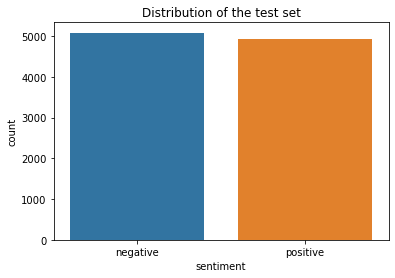

In [11]:
sns.countplot(x=y_test).set(title='Distribution of the test set')

Observamos que las distribuciones en los conjuntos de entrenamiento y prueba son prácticamente iguales y no tenemos class imbalance.

A continuación, queremos ver qué palabras son las que más se repiten. Para ello, vectorizaremos el corpus y sumaremos cada fila para calcular cuántas veces aparece cada palabra.

In [12]:
#Primero vectorizamos las reviews
cv = CountVectorizer()
cv_matrix = cv.fit_transform(df['review'])
cv_matrix

<50000x101895 sparse matrix of type '<class 'numpy.int64'>'
	with 6826529 stored elements in Compressed Sparse Row format>

In [13]:
# Nº de veces que aparece cada palabra == suma de su correspondiente columna
# Sacamos las sumas
totales = np.squeeze(np.asarray(np.sum(cv_matrix, axis = 0)))
# Ordenamos y nos quedamos con los 20 mejores índices
top20 = np.argsort(totales)[-20:]
top20

array([ 62917,  64110, 101096,  33226,  13654,  99740,  34443,  60214,
         6166,  98149,  90137,  90455,  44763,  46902,  12041,  46765,
        91217,  63757,   4541,  90160])

In [14]:
# Enseñamos las 20 palabras más repetidas
cv.get_feature_names_out()[top20]

array(['not', 'on', 'you', 'film', 'but', 'with', 'for', 'movie', 'as',
       'was', 'that', 'this', 'in', 'it', 'br', 'is', 'to', 'of', 'and',
       'the'], dtype=object)

Podemos ver que las palabras que más aparecen (como tabmién es de esperar) son preposiciones, pronombres, etc que no aportan mucho a la clasificación del documento, por tanto será importante normalizarlo para eliminar estas stopwords. Este es el caso de palabras como ``this``, ``that``, ``and``, ``you``... o incluso de la notación html para el salto de línea ``br``.

In [15]:
wpt = nltk.WordPunctTokenizer()
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/quiquequeipodellano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
norm_corpus = normalize_corpus(df['review'])
norm_corpus

array(['one reviewers mentioned watching oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well ma

In [17]:
#Primero vectorizamos las reviews
cv = CountVectorizer()
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix

<50000x175583 sparse matrix of type '<class 'numpy.int64'>'
	with 4987630 stored elements in Compressed Sparse Row format>

In [18]:
# Nº de veces que aparece cada palabra == suma de su correspondiente columna
# Sacamos las sumas
totales = np.squeeze(np.asarray(np.sum(cv_matrix, axis = 0)))
# Ordenamos y nos quedamos con los 20 mejores índices
top20 = np.argsort(totales)[-20:]
top20

array([ 55513, 114935,  10843,   4525,  64488,  61478, 169350, 101915,
       148067, 136112, 125769, 156651, 172826,  49868,  63233,  88361,
       109560,  54626, 101168,  18449])

In [19]:
# Enseñamos las 20 palabras más repetidas
cv.get_feature_names_out()[top20]

array(['first', 'people', 'bad', 'also', 'great', 'get', 'well', 'much',
       'story', 'see', 'really', 'time', 'would', 'even', 'good', 'like',
       'one', 'film', 'movie', 'br'], dtype=object)

Una vez normalizado el documento, vemos que el top20 de palabras más repetidas ha pasado a tener adejtivos y sustantivos que sí proyectan cierto significado, aunque no nos hemos librado del ``br``. En concreto nos interesarán palabras como ``bad`` o ``great`` ya que incluyen el significado positivo/negativo que andamos buscando para la clasificación de los textos del problema.



## 2) Estudio del efecto de distintas representaciones y distintos algoritmos para resolver la tarea

Construye distintas representaciones vectoriales basadas en lo contado en las clases de teoría (bolsas de palabras con 2 configuraciones distintas significativas) y utilízalas con 2 de los algoritmos estudiados (árboles de decisión y naive bayes)

Para una única configuración, muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?


#### Procederemos como en el tutorial, esto es, generar una bolsa de palabras con TF-IDF  con un vocabulario previamente elaborado y, por otro lado, usaremos un  con una vectorización binaria que infiera el vocabulario.

Para ello crearemos dos objetos de tipo `CountVectorizer` distintos. 

El primero objeto `vectorizer_binary` correpondrá a la opción 1, que será crear la bolsa de palabras y obteniendo el diccionario inferido por `CountVectorizer`. Además, esta opción será de tipo binaria, es decir, contaremos la presencia/ausencia de las palabras en un texto y no su frecuencia. 

El segundo objeto `vectorizer_dict` correspondrá a la opción 2. Obtendremos las frecuencias de los términos de los documentos con un diccionario elaborado previamente y dado por el fichero ``words.txt``. Utilizaremos TF-IDF para crear la bolsa de palabras y entrenar con ella los modelos.

Lo que queremos comprobar con estas configuraciones es si el trabajo (más complejo) de incluir un diccionario con más palabras y usar TF-IDF merecerá la pena frente a una versión más simple como es la binaria. El hecho de que pensemos que la versión binaria pueda ofrecer los mismos resultados con menos trabajo se debe a la naturaleza del problema. Al ser un problema de _sentiment analyisis_ en textos, nos importa conocer la presencia/ausencia de palabras con significado positivo/negativo como ``bad`` o ``great`` más allá que su frecuencia.

En ambos casos, entrenaremos los modelos de clasificación de ML `DecisionTreeClassifier` y `NaiveBayes`.



#### Configuración 1: Obteniendo la presencia/ausencia de términos sin diccionario 

El primer paso es obtener la presencia de las palabras con `CountVectorizar` y lo haremos usando el diccionario que se inferirá de los términos de los documentos que se le pasan al `CountVectorizer` (esta opción es el funcionamiento por defecto por tanto no hay que hacer nada).  También queremos usar la lista de palabras que proporciona sklearn para el inglés (parámetro `stop_words` con el valor `english`) y ponemos el parámetro `binary` a `True` para binarizarlo como comentábamos.

In [20]:
#Hacemos una copia de los conjuntos
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [21]:
vectorizer_binary = CountVectorizer(binary=True, stop_words='english')
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data_binary=vectorizer_binary.fit_transform(X_train_copy)

Vamos a ver cómo han quedado los términos con los parámetros por defecto y cuántos términos hay.

In [22]:
feature_names_binary = vectorizer_binary.get_feature_names_out()

print(len(feature_names_binary))
print(feature_names_binary[:100])
print(feature_names_binary[-100:])

92510
['00' '000' '0000000000001' '00000001' '00001' '00015' '000dm' '000s'
 '001' '003830' '006' '007' '0079' '007s' '0080' '0083' '009' '0093638'
 '00am' '00o' '00pm' '00s' '00schneider' '01' '01pm' '02' '020410' '0230'
 '029' '03' '039' '04' '05' '050' '05nomactr' '06' '0615' '06th' '07'
 '07b' '08' '087' '08th' '09' '0f' '0ne' '0r' '0s' '0tt' '10' '100' '1000'
 '10000' '1000000' '10000000000000' '10000th' '1000s' '1000th' '1001'
 '1004' '100b' '100bt' '100ft' '100ibs' '100k' '100m' '100miles' '100min'
 '100mins' '100s' '100th' '100x' '100yards' '101' '101st' '102' '102nd'
 '103' '104' '1040' '1040a' '1040s' '105' '1050' '106' '106min' '107'
 '108' '1080p' '109' '10_' '10am' '10ft' '10ish' '10k' '10lines' '10min'
 '10mins' '10minutes' '10pm']
['zues' 'zuf' 'zuger' 'zugsmith' 'zugurt' 'zukor' 'zukovic' 'zula'
 'zuleika' 'zuleikha' 'zuleta' 'zulu' 'zulus' 'zumhofe' 'zungia' 'zuni'
 'zuniga' 'zunz' 'zuotian' 'zurer' 'zurich' 'zurlini' 'zurn' 'zutaut'
 'zuucka' 'zvonimir' 'zvyagvatsev' 

`CountVectorizer` ha inferido un total de 92510 palabras en los textos.

In [23]:
print(train_vector_data_binary[train_sample_index])

  (0, 34598)	1
  (0, 47897)	1
  (0, 54654)	1
  (0, 22723)	1
  (0, 45543)	1
  (0, 30230)	1
  (0, 73898)	1
  (0, 2100)	1
  (0, 30284)	1
  (0, 71487)	1
  (0, 91173)	1
  (0, 46788)	1
  (0, 37674)	1
  (0, 10070)	1
  (0, 39050)	1
  (0, 20832)	1
  (0, 72040)	1
  (0, 25989)	1
  (0, 11851)	1
  (0, 39201)	1
  (0, 88944)	1
  (0, 47238)	1
  (0, 87030)	1
  (0, 9025)	1
  (0, 13710)	1
  :	:
  (0, 48655)	1
  (0, 107)	1
  (0, 91585)	1
  (0, 15017)	1
  (0, 1101)	1
  (0, 15836)	1
  (0, 23950)	1
  (0, 73839)	1
  (0, 11930)	1
  (0, 60290)	1
  (0, 12737)	1
  (0, 27201)	1
  (0, 40953)	1
  (0, 91189)	1
  (0, 49765)	1
  (0, 79150)	1
  (0, 16946)	1
  (0, 83199)	1
  (0, 26255)	1
  (0, 51231)	1
  (0, 55907)	1
  (0, 60423)	1
  (0, 14285)	1
  (0, 39209)	1
  (0, 61964)	1


Vamos a mostrar los términos presentes en los mensajes de antes

In [24]:
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [25]:
#write_terms(feature_names, train_data.data, train_vector_data, 10)
write_terms(feature_names_binary, X_train_copy.values, train_vector_data_binary, train_sample_index)

Mensaje [24285] : ['One of the commenter\'s is wrong. This is not the only Pat Patterson film and he didn\'t die two years after this was made. He shot a film called the "Electric Chair" in Pineville, NC. He shot this a few years after Doctor Gore. Patterson died in the late 70\'s. I know this because he used my house and he left a cat there!! It sucked also. This was a big deal when the movie came out. No independent horror films were being made in NC. This movie didn\'t help matters. Patterson used to do gore effects for H. G. Lewis. He was also good at magic. His gore scenes in Body shop were actually well done. The film was shot in a building that also housed a 7/11. You can actually see the tops of the walls in some scenes. The budget was less that $20,000 and the script looked like a child wrote it. Only Patterson could understand it. Still...it\'s entertainment and it\'s a classic.']
Mensaje [24285] vectorizado: ['000' '11' '20' '70' 'actually' 'big' 'body' 'budget' 'building' '

Observamos cierto ruido con términos alfanúmericos inferidos "erróneamente" como puede ser '70' inferido por la referencia a los años setenta (70's en inglés) o la palabra '000' inferida tras la coma de '$ 20,000' y el acrónimo 'nc' (de North Carolina)

Para probar los clasificadores en el conjunto de prueba, debemos transformar también los mensajes en bolsas de palabras `CountVectorizer` ajustado con el conjunto de entrenamiento.

In [26]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data_binary=vectorizer_binary.transform(X_test_copy)

## Entrenando los modelos de aprendizaje automático

Vamos a probar los clasificadores que ya conocemos en el problema de clasificación de textos.

La versión que vamos a usar de los clasificadores es la versión por defecto. Sin embargo, es posible encontrar mejores clasificadores buscando combinaciones de parámetros más adecuadas durante el aprendizaje. 

### Árbol de decisión 

In [27]:
# Creamos el clasificador con los valores por defecto
# Los parámetros por defecto son : (criterion='gini', max_depth = None, min_samples_split=2,min_samples_leaf=1)
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_vector_data_binary, y_train)

tree_train_predictions = tree_classifier.predict(train_vector_data_binary)
tree_test_predictions = tree_classifier.predict(test_vector_data_binary)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.7201


Podemos ver un fuerte sobre-aprendizaje, con una precisión en entramiento de 1.0 mientras que en test sólo contamos con un 72% de aciertos. Sería conveniente mejorar el árbol modificando los parámetros de entrenamiento para que aumente la capacidad de generalización del árbol.

Vamos a probar a intentar optmizar el parámetro `max_depth` del árbol. Aunque se espera que sea una tarea un poco costosa en tiempo, nos interesa comprobar si obtenemos mejoras significativas por "tunear" este parámetro. **AVISO TARDA UNOS (VARIOS) MINUTOS.**

In [28]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(2, 11)
for md in max_depths: 
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, train_vector_data_binary, y_train, scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy

([0.6564,
  0.6774,
  0.6806805555555556,
  0.6981555555555555,
  0.7096777777777777,
  0.7173666666666667,
  0.7252666666666667,
  0.7321722222222222,
  0.7423194444444444],
 [0.6564000000000001,
  0.6773999999999999,
  0.6795,
  0.6946749999999999,
  0.70305,
  0.70915,
  0.711775,
  0.713375,
  0.7179])

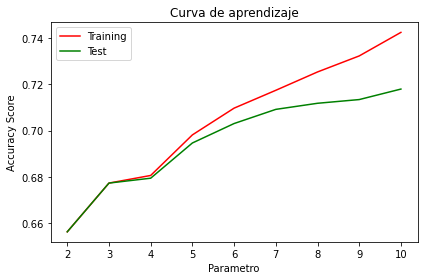

In [29]:
# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  

Observamos que entre los valores 8 y 10 no se mejora mucho en el conjunto de prueba mientras que sí aprende mucho del conjunto de entrenamiento, por lo que nos quedamos con un valor de `max_depth` de 8. Creamos un árbol con este valor.

In [31]:
dt = tree.DecisionTreeClassifier(criterion="gini",max_depth=8,min_samples_split=2,random_state = RANDOM_STATE)
dt.fit(train_vector_data_binary,y_train)

tree_train_predictions = dt.predict(train_vector_data_binary)
tree_test_predictions = dt.predict(test_vector_data_binary)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en entrenamiento: 0.72175
Árbol, porcentaje de aciertos en test: 0.7017


La mejora no es muy significativa, parece ser parecido en test al clasificador por defecto.

### Naive Bayes

Vamos a trabajar con el **NB Multinomial**.

 - __Naive Bayes Multinomial__ que se utiliza cuando las variables son enteras (como el número de apariciones de cada palabra en el documento) pero también se "traga" datos con decimales (como el valor TF/IDF). No admite números negativos.
     - En algunos problemas, como en el análisis de sentimiento (*sentiment analysis*) de un texto, lo importante puede ser la presencia o ausencia de palabras que indiquen un sentimiento positivo o negativo, y no tanto su frecuencia. En estos casos se puede utilizar una versión binarizada del Naive Bayes Multinomial basada en la representación binarizada de los vectores bolsa de palabras (CountVectorizer con el parámetro binary=True).


In [32]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(train_vector_data_binary, y_train)

mnb_train_predictions = mnb_classifier.predict(train_vector_data_binary)
mnb_test_predictions = mnb_classifier.predict(test_vector_data_binary)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.906425
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8582


A la vista de los resultados, podemos observar que el clasificador Naive Bayes se comporta mejor para esta vectorización, dado que obtenemos un 90% de aciertos en entrenamiento pero también un 86% de aciertos en test, lo cuales son resultados bastante satisfactorios.

#### Configuración 2: Obteniendo las frecuencias de los documentos con un diccionario previamente elaborado

In [33]:
#Hacemos una copia de los conjuntos
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [34]:
# Pasamos el fichero a una lista (una línea por item)

with open('words.txt') as f:
    dictionary = f.read().splitlines()

# El diccionario cargado lo pasamos en el parámetro vocabulary    
vectorizer_dict = CountVectorizer(vocabulary=dictionary, stop_words='english')

Vamos a ver cuántos términos hay en el diccionario, veremos que hay muchos más términos en un diccionario de propósito general que en uno inferido de un corpus de textos sobre un pequeño subconjunto de temas. 

Recuerda que esto no quiere decir que el diccionario cargado contenga todos los términos del diccionario inferido porque este puede tener palabras propias (jerga, nombres comerciales, etc) y términos alfanuméricos que también observamos.

In [35]:
feature_names = vectorizer_dict.get_feature_names_out()

print(len(feature_names))
print(feature_names[:100])
print(feature_names[-100:])

466550
['2' '1080' '&c' '10-point' '10th' '11-point' '12-point' '16-point'
 '18-point' '1st' '2,4,5-t' '2,4-d' '20-point' '2D' '2nd' '30-30' '3D'
 '3-D' '3M' '3rd' '48-point' '4-D' '4GL' '4H' '4th' '5-point' '5-T' '5th'
 '6-point' '6th' '7-point' '7th' '8-point' '8th' '9-point' '9th' 'a' "a'"
 'a-' 'A&M' 'A&P' 'A.' 'A.A.A.' 'A.B.' 'A.B.A.' 'A.C.' 'A.D.' 'A.D.C.'
 'A.F.' 'A.F.A.M.' 'A.G.' 'A.H.' 'A.I.' 'A.I.A.' 'A.I.D.' 'A.L.' 'A.L.P.'
 'A.M.' 'A.M.A.' 'A.M.D.G.' 'A.N.' 'a.p.' 'a.r.' 'A.R.C.S.' 'A.U.'
 'A.U.C.' 'A.V.' 'a.w.' 'A.W.O.L.' 'A/C' 'A/F' 'A/O' 'A/P' 'A/V' 'A1'
 'A-1' 'A4' 'A5' 'AA' 'AAA' 'AAAA' 'AAAAAA' 'AAAL' 'AAAS' 'Aaberg'
 'Aachen' 'AAE' 'AAEE' 'AAF' 'AAG' 'aah' 'aahed' 'aahing' 'aahs' 'AAII'
 'aal' 'Aalborg' 'Aalesund' 'aalii' 'aaliis']
['Zsigmondy' 'Zsolway' 'ZST' 'ZT' 'Ztopek' 'Zubeneschamali' 'Zubird'
 'Zubkoff' 'zubr' 'Zuccari' 'zuccarino' 'Zuccaro' 'Zucchero' 'zucchetti'
 'zucchetto' 'zucchettos' 'zucchini' 'zucchinis' 'zucco' 'zuchetto'
 'Zucker' 'Zuckerman' 'zudda'

Observamos que el diccionario contiene 466550 términos que son bastantes más que los 92510 inferidos por `CountVectorizer`

In [36]:
train_vector_data = vectorizer_dict.fit_transform(X_train_copy)

print(train_vector_data[train_sample_index])

/Users/quiquequeipodellano/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:1379: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


  (0, 3803)	2
  (0, 41526)	1
  (0, 53315)	1
  (0, 56906)	1
  (0, 65086)	1
  (0, 73885)	1
  (0, 79815)	1
  (0, 96504)	1
  (0, 105262)	2
  (0, 105310)	1
  (0, 118722)	1
  (0, 120032)	1
  (0, 125116)	1
  (0, 138922)	3
  (0, 138962)	1
  (0, 170695)	1
  (0, 180592)	1
  (0, 181233)	1
  (0, 184492)	2
  (0, 208542)	1
  (0, 213042)	1
  (0, 214775)	1
  (0, 217830)	1
  (0, 221809)	1
  (0, 225242)	1
  (0, 230581)	1
  (0, 246767)	2
  (0, 351069)	2
  (0, 363663)	1
  (0, 364006)	3
  (0, 390822)	1
  (0, 428524)	1
  (0, 445153)	2
  (0, 463923)	1
  (0, 463985)	1


In [37]:
# Calculamos el valor TF-IDF 

tfidfer = TfidfTransformer()
train_preprocessed = tfidfer.fit_transform(train_vector_data)
# Sacamos los valores TF-IDF para el ejemplo que habíamos enseñado antes.
print(train_preprocessed[train_sample_index])

  (0, 463985)	0.15515437446785663
  (0, 463923)	0.11980827419042349
  (0, 445153)	0.23423480271708225
  (0, 428524)	0.12223685060809293
  (0, 390822)	0.18195649724615048
  (0, 364006)	0.3515976796269458
  (0, 363663)	0.18037724371007333
  (0, 351069)	0.18113570598787906
  (0, 246767)	0.0948311172833854
  (0, 230581)	0.1839998569306483
  (0, 225242)	0.16651893085826933
  (0, 221809)	0.13544983735290697
  (0, 217830)	0.056124073930867276
  (0, 214775)	0.11495151669705184
  (0, 213042)	0.1315599228099515
  (0, 208542)	0.08373410570328323
  (0, 184492)	0.18793271856976076
  (0, 181233)	0.2867929167118932
  (0, 180592)	0.11014397256734582
  (0, 170695)	0.11931654074379404
  (0, 138962)	0.08557336265088715
  (0, 138922)	0.15127192111119195
  (0, 125116)	0.1422663462875435
  (0, 120032)	0.21416895329169713
  (0, 118722)	0.11420787983155406
  (0, 105310)	0.15645708287398882
  (0, 105262)	0.18910345841995763
  (0, 96504)	0.14523617258299013
  (0, 79815)	0.25110364223294623
  (0, 73885)	0.120424


Vamos a ver los términos extraídos para los mensajes de antes.

In [38]:
#write_terms(feature_names, train_data.data, train_vector_data, 10)
write_terms(feature_names, X_train_copy.values, train_vector_data, train_sample_index)

Mensaje [24285] : ['One of the commenter\'s is wrong. This is not the only Pat Patterson film and he didn\'t die two years after this was made. He shot a film called the "Electric Chair" in Pineville, NC. He shot this a few years after Doctor Gore. Patterson died in the late 70\'s. I know this because he used my house and he left a cat there!! It sucked also. This was a big deal when the movie came out. No independent horror films were being made in NC. This movie didn\'t help matters. Patterson used to do gore effects for H. G. Lewis. He was also good at magic. His gore scenes in Body shop were actually well done. The film was shot in a building that also housed a 7/11. You can actually see the tops of the walls in some scenes. The budget was less that $20,000 and the script looked like a child wrote it. Only Patterson could understand it. Still...it\'s entertainment and it\'s a classic.']
Mensaje [24285] vectorizado: ['actually' 'big' 'building' 'called' 'chair' 'classic' 'commenter'

Ahora no observamos ruido en las palabras seleccionadas (en concreto han desparecido los caracteres númericos que mencionábamos), pero hemos perdido otras palabras como ``budget`` o ``gore`` (que es jerga para escenas violentas o sangrientas) que nos podrían ayudar a clasificar y que no están en el diccionario.

In [39]:
# Tomamos los textos del conjunto de test y los transformamos en una matriz
# de palabras. Al usar "transform" toma como referencia únicamente las palabras
# encontradas en el conjunto de entrenamiento
test_vector_data=vectorizer_dict.transform(X_test_copy)
# Calculamos el valor TF-IDF 
# Al usar "transform" toma como IDF el del conjunto de entrenamiento 
test_preprocessed=tfidfer.transform(test_vector_data)

### Entrenando los modelos de aprendizaje automático. Configuración 2.

Vamos a probar los clasificadores que ya conocemos en el problema de clasificación de textos.

La versión que vamos a usar de los clasificadores es la versión por defecto. Sin embargo, es posible encontrar mejores clasificadores buscando combinaciones de parámetros más adecuadas durante el aprendizaje. 

#### Árbol de decisión 

In [40]:
# Creamos el clasificador con los valores por defecto
# Los parámetros por defecto son : (criterion='gini', max_depth = None, min_samples_split=2,min_samples_leaf=1)
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_preprocessed, y_train)

tree_train_predictions = tree_classifier.predict(train_preprocessed)
tree_test_predictions = tree_classifier.predict(test_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.7213


Podemos ver un fuerte sobre-aprendizaje, con una precisión de 1.0 en entrenamiento mientras que del 72% en test. Sería conveniente mejorar el árbol modificando los parámetros de entrenamiento para que aumente la capacidad de generalización del árbol.

Vamos a probar a intentar optmizar el parámetro `max_depth` del árobl. Aunque se espera que sea una tarea un poco costosa en tiempo, nos interesa comprobar si obtenemos mejoras significativas por "tunear" este parámetro. **AVISO TARDA UNOS (VARIOS) MINUTOS**

In [41]:
train_accuracy = []
test_accuracy = []

# Entrenamos y validamos varios árboles con distintas profundidades máximas
max_depths = range(2, 11)
for md in max_depths: 
    clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=md, min_samples_split=2, random_state=RANDOM_STATE)
    scores = cross_validate(clf, train_preprocessed, y_train, scoring='accuracy', cv=10, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))
    
train_accuracy, test_accuracy

([0.6562722222222223,
  0.6802333333333334,
  0.6976277777777777,
  0.7006166666666667,
  0.7122611111111111,
  0.7231388888888889,
  0.7329,
  0.7390722222222224,
  0.7476888888888888],
 [0.6554749999999999,
  0.6791499999999999,
  0.6956,
  0.6970250000000001,
  0.7045250000000001,
  0.713,
  0.721025,
  0.7235249999999999,
  0.728325])

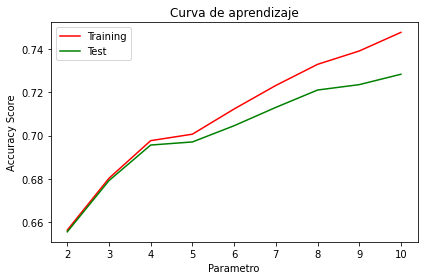

In [42]:
# Draw lines
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

# Create plot
plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()  

Observamos que entre los valores 8 y 10 no se mejora mucho en el conjunto de prueba mientras que sí se mejora en el conjunto de entrenamiento, por lo que nos quedamos con un valor de `max_depth` de 8. Creamos un árbol con este valor.

In [43]:
dt = tree.DecisionTreeClassifier(criterion="gini",max_depth=8,min_samples_split=2,random_state = RANDOM_STATE)
dt.fit(train_preprocessed,y_train)

tree_train_predictions = dt.predict(train_preprocessed)
tree_test_predictions = dt.predict(test_preprocessed)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en entrenamiento: 0.73255
Árbol, porcentaje de aciertos en test: 0.7147


Observamos que no hemos obtenido ninguna mejora, obtenemos resultados como en el clasificador por defecto.

#### Naive Bayes

In [44]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_preprocessed, y_train)

mnb_train_predictions = mnb_classifier.predict(train_preprocessed)
mnb_test_predictions = mnb_classifier.predict(test_preprocessed)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.897075
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8567


Observamos de nuevo lo mismo, el Naive Bayes parece generalizar mejor que el árbol de decisión y arroja mejores resultados, además de ser menos costoso en tiempo. 

En general, los resultados han variado en +-1% por lo que son bastante parecidos a la otra vectorización, es decir, vectorizar sin diccionario y con binary = True es lo suficientemente bueno para este problema.

## 3) Análisis comparativo final

Se han entrenado varios clasificadores usando vectorizaciones diferentes de los datos. Compara las diferencias entre representaciones para un mismo algoritmo y entre algoritmos. Explica a qué crees que se deben las diferencias.

Analiza con detalle el mejor clasificador de cada tipo. Indica las palabras más relevantes. Busca un ejemplo mal clasificado de cada clase, justifica el error ¿se te ocurre alguna forma de solucionarlo?


Hemos observado en el apartado anterior, que el clasificador `Naive Bayes` se comporta mejor en ambos casos que el árbol de decisión. Además no hemos obtenido una diferencia muy significativa en los comportamientos entre las distintas vectorizaciones. Como el conjunto de datos es grande, es posible que no haya una gran diferencia entre imponer el vocabulario o no, ya que el inferido por CountVectorizer puede ser lo suficientemente bueno. Por otro lado, como hemos visto, realmente para el tipo de problema (_sentiment analysis_) no es realmente necesario utilizar el TF-IDF para obtener prácticamente los mismos resultados, ya que nos ha bastado con hacer `CountVectorizer` con binary = True. Dado que obtienen los mismos resulados, exponemos dichos resultados para uno de los dos. Lo hacemos para el binario

In [45]:
# Creamos el clasificador con los valores por defecto
# Los parámetros por defecto son : (criterion='gini', max_depth = None, min_samples_split=2,min_samples_leaf=1)
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(train_vector_data_binary, y_train)

tree_train_predictions = tree_classifier.predict(train_vector_data_binary)
tree_test_predictions = tree_classifier.predict(test_vector_data_binary)

print("Árbol, porcentaje de aciertos en entrenamiento:", np.mean(tree_train_predictions == y_train))
print("Árbol, porcentaje de aciertos en test:", np.mean(tree_test_predictions == y_test))

Árbol, porcentaje de aciertos en entrenamiento: 1.0
Árbol, porcentaje de aciertos en test: 0.7198


In [46]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(train_vector_data_binary, y_train)

mnb_train_predictions = mnb_classifier.predict(train_vector_data_binary)
mnb_test_predictions = mnb_classifier.predict(test_vector_data_binary)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == y_train))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == y_test))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.906425
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.8582


In [47]:
# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions_tree = tree_test_predictions

print(classification_report(y_test, predictions_tree, target_names=y_test.unique()))

              precision    recall  f1-score   support

    negative       0.72      0.73      0.72      5082
    positive       0.72      0.71      0.71      4918

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [48]:
# NOTA: Aquí elegimos analizar un determinado clasificador y sus predicciones 
# Por ejemplo el naive bayes
#classifier=mnb_classifier
predictions_mnb = mnb_test_predictions

print(classification_report(y_test, predictions_mnb, target_names=y_test.unique()))

              precision    recall  f1-score   support

    negative       0.85      0.88      0.86      5082
    positive       0.87      0.84      0.85      4918

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



En el caso del Naive Bayes Multinomial ambas clases se clasifican muy bien con muy buena precisión, exhaustividad y medida F1. Los resultados son en torno al 10% mejores en todas las clases y medidas con respecto al árbol.

Podemos echar un vistazo a las matrices de confusión para entender mejor este problema.

(array([0.5, 1.5]), [Text(0.5, 0, 'negative'), Text(1.5, 0, 'positive')])

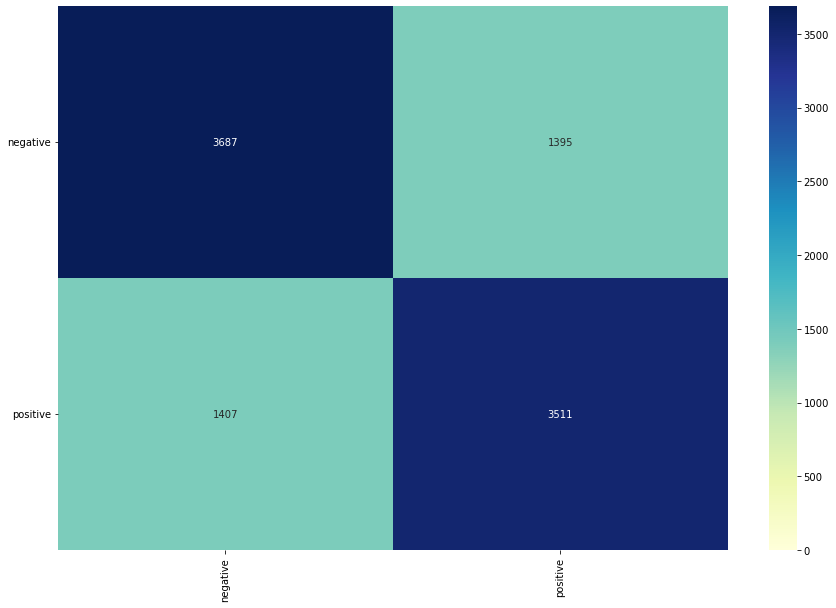

In [49]:
conf_matrix = confusion_matrix(y_test, predictions_tree)
conf_matrix_df = pd.DataFrame(conf_matrix, index=y_test.unique(), columns=y_test.unique())

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

(array([0.5, 1.5]), [Text(0.5, 0, 'negative'), Text(1.5, 0, 'positive')])

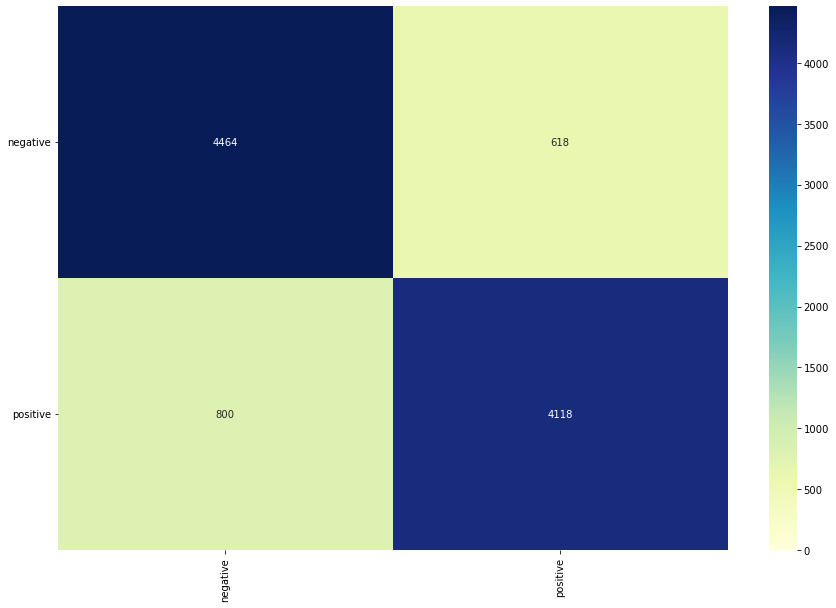

In [50]:
conf_matrix = confusion_matrix(y_test, predictions_mnb)
conf_matrix_df = pd.DataFrame(conf_matrix, index=y_test.unique(), columns=y_test.unique())

plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix_df, annot=True, vmin=0, vmax=conf_matrix.max(), fmt='d', cmap="YlGnBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)

Podemos recalcar los buenos resultados del clasificador `Naive Bayes`, sobretodo en la clase ``negative``, que parece clasificar un poco mejor que la ``positive``. El árbol falla en cada clase en torno al doble de ejemplos que el clasificador MNB

### Importancia de las variables 

Algunos algoritmos de clasificación permiten analizar cuáles son las variables más relevantes para la clasificación. Suele ser una buena idea para entender mejor los resultados analizar esas variables. En el caso de nuestro problema, lo que nos diría sería qué palabras son más útiles para realizar la clasificación. 

Este tipo de análisis es muy dependiente de la técnica que estemos utilizando, de los fundamentos en los que se base dicha técnica. De hecho, no todas las técnicas permiten hacer estos análisis ya que algunas son más "caja negra" que otras. 

#### Árboles de decisión

En el caso de los árboles de decisión podemos obtener las variables con mayor poder de discriminación en el árbol obtenido, es decir, aquellas que mayor reducción de Gini han producido a lo largo del árbol.

In [51]:
def print_top20_features_in_trees(vectorizer, clf):
    """Prints features with the highest coefficient values"""
    feature_names = vectorizer.get_feature_names_out()
    
    top20 = np.argsort(clf.feature_importances_)[-20:]
    reversed_top = top20[::-1]
    print("Top 20 features in the tree\n")
    print("%s" % ( " / ".join(feature_names[j] for j in reversed_top)))

In [52]:
print_top20_features_in_trees(vectorizer_binary,tree_classifier)

Top 20 features in the tree

bad / worst / great / waste / awful / boring / excellent / best / terrible / wonderful / stupid / poor / supposed / minutes / worse / love / horrible / lame / dull / perfect


En este caso es muy claro que estamos encontrando palabras que rápidamente nos remiten a alguno de los dos sentimientos posibles: ``bad``,``worst``,``waste``,``awful``,``boring`` etc son palabras con connotación negativa y que probablemente se encuentren en un texto así clasificado, mientras que lo contrario ocurriría para ``excellent``,``best``,``wonderful``...

#### Naive Bayes

En el caso del Naive Bayes, por cada una de las clases a predecir, podemos obtener aquellas palabras que es más verosímil que aparezcan.  

In [53]:
def print_top20_features_per_class_in_NB(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    print("Top 20 features per class\n")
    for i, class_label in enumerate(class_labels):
        top20 = np.argsort(clf.feature_log_prob_[i])[-20:]
        reversed_top = top20[::-1]
        
        print("%s: %s" % (class_label,
              " / ".join(feature_names[j] for j in reversed_top)),'\n')
        
        #Descomentar para ver el índice de los términos en el diccionario
        #print("%s " % (" / ".join(str(j) for j in reversed_top)),'\n')

In [54]:
print_top20_features_per_class_in_NB(vectorizer_binary,mnb_classifier,y_test.unique())       

Top 20 features per class

negative: movie / br / film / like / just / good / bad / time / really / don / make / story / acting / people / plot / way / movies / watch / think / better 

positive: br / film / movie / like / good / just / time / great / story / really / best / people / way / love / seen / life / don / watch / think / make 



En general, vemos que hay las palabras tienen bastante sentido. Independientemente de la clase, las palabras ``movie``, ``film``, ``character(s)`` tienes altas probabilidades de aparecer aunque no nos transmitan información específica sobre la clase (así de nuevo como la notación ``br``de html). Observamos también que la palabra ``bad`` aparece a la hora de clasificar como ``negative`` lo cual tiene mucho sentido ya que uno puede esperar que si el text contiene ``bad`` es muy probable que la review sea ``negative``. O palabras como ``like`` que aunque pueden querer decir gustar, también pueden significar como, y que en cualquier caso parecen palabras casi vacías (otro caso similar es el de ``does`` o el de ``think``). En la clase positive también aparecen palabras como ``great`` o ``love`` (que aunque significa amor, también puede significar que le gustó la película)

Vamos ahora a encontrar ejemplos mal clasificados para clase:

In [100]:
#Filtrado de los que cumplen la condicion "falso positivo" o "falso negativo"
wrong_positives = np.where((predictions_mnb == 'positive') & (y_test == 'negative'))[0]
wrong_negatives = np.where((predictions_mnb == 'negative') & (y_test == 'positive'))[0]


# Mostrar un ejemplo mal clasificado para cada clase
print("Ejemplo mal clasificado para clase 'positive': ", X_test.iloc[wrong_positives[0]])
print('\n')
print("Ejemplo mal clasificado para clase 'negative': ", X_test.iloc[wrong_negatives[-1]])

Ejemplo mal clasificado para clase 'positive':  I'm a huge fan of both Emily Watson (Breaking The Waves) and Tom Wilkinson (Normal) and was amused to see them upstaged by Rupert Everett (Dellamorte Dellamore) in this shockingly rather minor movie that had all the ingredients to be so much more. The too brief scenes in which he portrays a languid, infinitely entitled, worthless son of a rich Lord are spot-on and entertaining. But for a love triangle there was remarkably little chemistry to speak of between anyone. The music was annoyingly movie-of-the-week quality, and the voice-over jarring and totally unnecessary. Clearly the work of a first-time director with a small budget who either lacked or didn't sufficiently heed good advice. Too bad.<br /><br />I can appreciate how the people you kind of hate at the beginning are the ones you kind of like at the end, and vice-versa, so there is some sort of character arc, at least in terms of perception. For example, Watson's character, while 

Para el primer ejemplo es posible que esté mal clasificado ya que aparecen palabras como ``good`` o , a pesar de que el uso que se les de sea para expresar lo contario: "didn't sufficiently heed good advice" o "Good God!". Esto puede hacer que se clasifique como ``positive`` a pesar de ser una review claramente ``negative``.

El segundo ejemplo puede que esté mal clasificado debido a la presencia de palabras como ``horror`` o ``annoying``, que en el contexto no implican nada negativo sobre la película, ya que hablan dek argumento en sí de la película y no sobre cómo se siente el autor respecto a ella.